In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [11]:
data = pd.read_csv('data/AmesHousing.txt', sep='\t')
train = data[:1460]
test = data[1460:]
target = 'SalePrice'

In [6]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


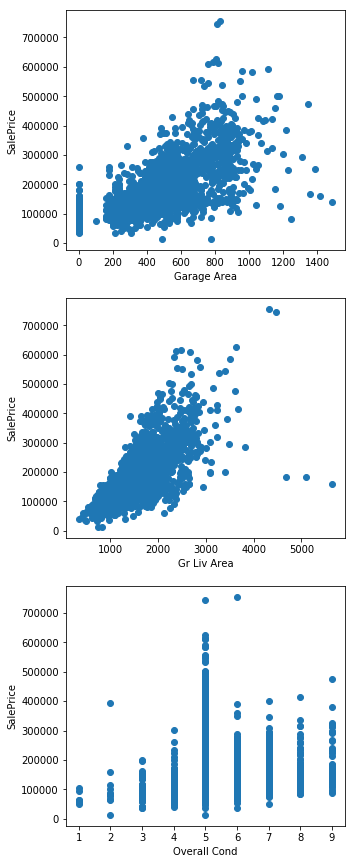

In [24]:
fig = plt.figure(figsize=(5, 15))

for i, feature in enumerate(['Garage Area', 'Gr Liv Area', 'Overall Cond'], 1):
    ax = fig.add_subplot(3, 1, i)
    ax.scatter(data[feature], data[target])
    ax.set_xlabel(feature)
    ax.set_ylabel(target)
plt.show()

In [28]:
corr = train[['Garage Area', 'Gr Liv Area', 'Overall Cond', 'SalePrice']].corr()
corr

,Garage Area,Gr Liv Area,Overall Cond,SalePrice
Garage Area,1.000000,0.465366,-0.132401,0.662397
Gr Liv Area,0.465366,1.000000,-0.133710,0.698990
Overall Cond,-0.132401,-0.133710,1.000000,-0.099395
SalePrice,0.662397,0.698990,-0.099395,1.000000


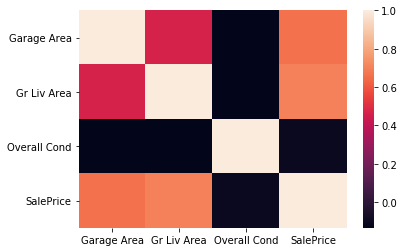

In [35]:
sns.heatmap(corr);

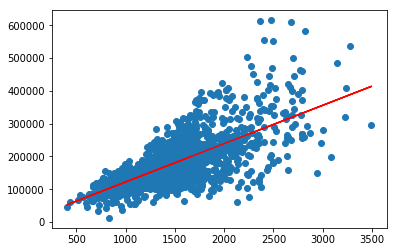

In [64]:
ln = LinearRegression()
ln.fit(train[['Gr Liv Area']], train['SalePrice'])
a1, a0 = ln.coef_, ln.intercept_

plt.scatter(train['Gr Liv Area'], train['SalePrice'])
plt.plot(train['Gr Liv Area'], train['Gr Liv Area'] * a1 + a0, color='red')
plt.show()

In [66]:
train_rmse = mean_squared_error(train['SalePrice'], ln.predict(train[['Gr Liv Area']])) ** (1/2)
test_rmse = mean_squared_error(test['SalePrice'], ln.predict(test[['Gr Liv Area']])) ** (1/2)

train_rmse, test_rmse

(56034.362001412796, 57088.25161263909)

In [65]:
cols = ['Overall Cond', 'Gr Liv Area']
lr = LinearRegression()
lr.fit(train[cols], train['SalePrice'])

train_rmse2 = mean_squared_error(train['SalePrice'], lr.predict(train[cols])) ** (1/2)
test_rmse2 = mean_squared_error(test['SalePrice'], lr.predict(test[cols])) ** (1/2)

train_rmse2, test_rmse2

(56032.39801525867, 57066.90779448559)

### Feature selection

In [78]:
cols_to_drop = ['PID', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold']
numerical_train = train.select_dtypes(include=['int', 'float']).drop(columns=cols_to_drop)

null_series = numerical_train.isna().sum()
full_cols_series = null_series[null_series == 0]
train_subset = train[full_cols_series.index]

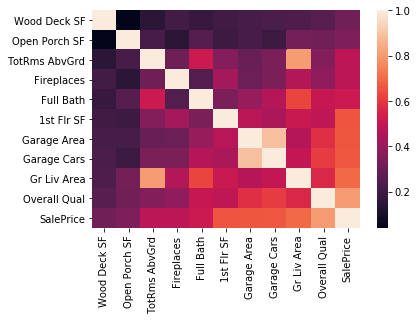

In [92]:
sorted_corrs = np.abs(train_subset.corr()['SalePrice']).sort_values()
strong_corrs = sorted_corrs[sorted_corrs > 0.3]
sns.heatmap(train_subset[strong_corrs.index].corr())

In [131]:
final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
features = final_corr_cols.drop(['SalePrice']).index
target = 'SalePrice'
clean_test = test[final_corr_cols.index].dropna()

lr = LinearRegression()
lr.fit(train_subset[features], train_subset[target])
train_rmse = mean_squared_error(train_subset[target], lr.predict(train_subset[features])) ** (1/2)
test_rmse = mean_squared_error(clean_test[target], lr.predict(clean_test[features])) ** (1/2)

train_rmse, test_rmse

(34173.97629185851, 41032.026120197705)

### Removing features with low variance

In [126]:
df_norm = (train[features] - train[features].min()) / (train[features].max() - train[features].min())
df_norm.describe().loc[['min', 'max']]
sorted_vars = df_norm.var().sort_values()
cutoff = 0.015
features = sorted_vars.drop(sorted_vars[sorted_vars < cutoff].index).index

In [130]:
lr = LinearRegression()
lr.fit(train[features], train[target])
train_rmse_2 = mean_squared_error(train[target], lr.predict(train[features])) ** (1/2)
test_rmse_2 = mean_squared_error(clean_test[target], lr.predict(clean_test[features])) ** (1/2)
train_rmse_2, test_rmse_2

(34372.696707783965, 40591.4270243773)